In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import pandas as pd

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# Testing normal graph

In [ ]:
# Normal test graph

delegations_orig, nodes = create_delegation_graph(5, 0, seed=0)


In [ ]:
delegations = graph_tools.invert_graph(delegations_orig)

In [ ]:
print("LE model")
print(le.resolve_delegations(delegations, nodes))

print("LP model")
powers, sinks = lp.resolve_delegations(delegations, nodes)
print(powers, sinks)


In [ ]:
le_model = le.set_up(delegations, nodes)
lp_model = lp.set_up(delegations, nodes)

In [ ]:
#viz.visualize_delegation_graph(delegations_orig, powers)

In [ ]:
%timeit le.solve(*le_model)
%timeit lp.solve(*lp_model)

Results:

LE: 3.43 μs ± 31.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

LP: 17.5 ms ± 384 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# Big Graph

In [ ]:
delegations_org, nodes = create_delegation_graph(10000, 100, seed=0)
delegations = graph_tools.invert_graph(delegations_org)

powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)

powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)

print(f"Found same sinks: {sinks_le == sinks_lp}")
print(f"Found same powers: {powers_le == powers_lp}")


le_model = le.set_up(delegations, nodes)
lp_model = lp.set_up(delegations, nodes)

powers_iter = iterative.iterate_delegations(delegations, nodes)

for node in sinks_le:
    if (powers_le[node] - powers_iter[node] < 0.01):
        continue
    else: 
        print("Found non-matching powers for Node", node, ":",  powers_le[node], powers_lp[node], powers_iter[node])

print("Unless indicated otherwise, the rounded powers found in the iterative model are also the same")

In [ ]:
%timeit le.solve(*le_model)
%timeit lp.solve(*lp_model)
%timeit iterative.iterate_delegations(delegations, nodes)

Results

10 000 nodes, 100 loops

LE: 4.13 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

**LP: 149 ms ± 768 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)**

Iter: 6.43 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Fine delegations

In [ ]:
fine_delegation_weight = 10 ** -2

delegations_org = {
    '0': {'1': fine_delegation_weight,
          '2': 1 - fine_delegation_weight},
    '2': {'0': 1}
}
nodes = ['0', '1', '2']
delegations = graph_tools.invert_graph(delegations_org)

powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)

powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)

print(f"Found same sinks: {sinks_le == sinks_lp}")
print(f"Found same powers: {powers_le == powers_lp}")


le_model = le.set_up(delegations, nodes)
lp_model = lp.set_up(delegations, nodes)

powers_iter = iterative.iterate_delegations(delegations, nodes)

print("Powers from LE:", powers_le)
print("Powers after iteration:", powers_iter)

#viz.visualize_delegation_graph(delegations_org, powers_iter)


In [ ]:
%timeit le.solve(*le_model)
print("")
%timeit lp.solve(*lp_model)
print("")
%timeit iterative.iterate_delegations(delegations, nodes)

## Results

LE

LP

Iterative

### fine_delegation_weight = 10 ** -2

**53.7 μs ± 1.47 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)**

20.2 ms ± 276 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

1.46 ms ± 14.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Notice, here, the LP solver is the slowest


### fine_delegation_weight = 10 ** -6

**53.3 μs ± 1.24 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)**

22.5 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

14 s ± 99.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Notice, that here, the iterative solver performs a lot worse, while the LP and LE solver's runtime barely changes.

### Note

This example is artificial, and not unrealistic, but an example of a similar power "trap" as the one describe above could be this:

```
<- 0.5 - A - 0.5 -> B - 0.9 ->  C - 0.9 ->  D

          <- 0.1 -   <- 0.1 -    <- 1 --

```


# Exploring Runtime Consistency

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


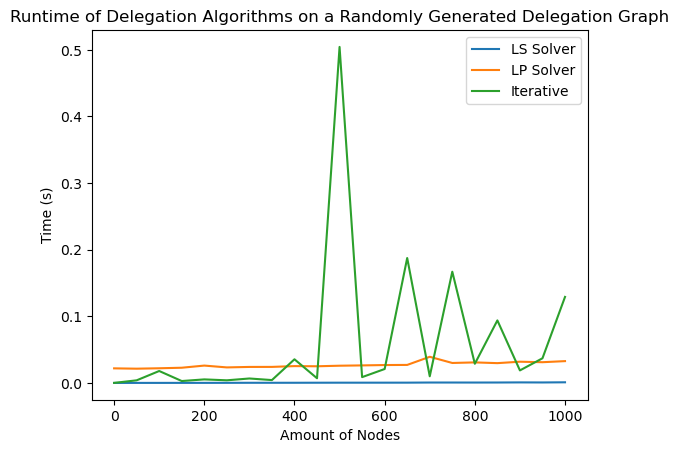

In [2]:
LOOPS = 3
SEED = 100

range_x = range(0, 1001, 50)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            delegations_orig, nodes = create_delegation_graph(num_nodes, LOOPS, seed=SEED)
            delegations= graph_tools.invert_graph(delegations_orig)
            try: 
                le_model = le.set_up(delegations, nodes)
                _ = le.resolve_delegations(delegations, nodes)
                break
            except:
                print(le_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 50

        # LE
        start_time = time.time()
        le_model = le.set_up(delegations, nodes)
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        start_time = time.time()
        lp_model = lp.set_up(delegations, nodes)
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
        
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
            continue
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)

    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms on a Randomly Generated Delegation Graph")
plt.show()

In [3]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
time_data_iterative
[[6.131887435913086e-05, 0.0038995909690856933, 0.017892870903015137, 0.002838118076324463, 0.005300517082214355, 0.003928699493408203, 0.006656601428985596, 0.004286317825317383, 0.03547260046005249, 0.0070088601112365725, 0.5043562030792237, 0.008695273399353028, 0.02088087558746338, 0.18749958515167237, 0.009929099082946778, 0.1669458818435669, 0.028725876808166503, 0.09384134292602539, 0.01878354072570801, 0.036984434127807615, 0.12910268306732178]]
time_data_le
[[2.70843505859375e-06, 3.436088562011719e-05, 4.677057266235351e-05, 7.059335708618163e-05, 8.275747299194336e-05, 0.00013316869735717772, 0.0002075314521789551, 0.0002128005027770996, 0.00023499011993408203, 0.0003020977973937988, 0.00036151885986328123, 0.0003625965118408203, 0.0003781843185424805, 0.0004045200347900391, 0.0005975198745727539, 0.000594644546508789, 0.0005678987503051758, 0.000623064

# Exploring the weird iterative runtime behavior

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


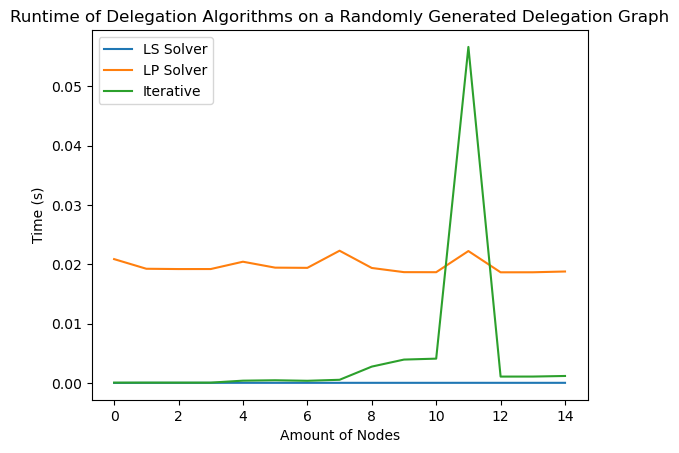

In [4]:
LOOPS = 3
SEED = 100

range_x = range(0, 15, 1)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            delegations_orig, nodes = create_delegation_graph(num_nodes, LOOPS, seed=SEED)
            delegations= graph_tools.invert_graph(delegations_orig)
            try: 
                le_model = le.set_up(delegations, nodes)
                _ = le.resolve_delegations(delegations, nodes)
                break
            except:
                print(le_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 50

        # LE
        start_time = time.time()
        le_model = le.set_up(delegations, nodes)
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        start_time = time.time()
        lp_model = lp.set_up(delegations, nodes)
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
        
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
            continue
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)

    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms on a Randomly Generated Delegation Graph")
plt.show()

In [5]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
time_data_iterative
[[6.006956100463867e-05, 6.18290901184082e-05, 5.944967269897461e-05, 6.0510635375976565e-05, 0.0003901004791259766, 0.00045835018157958985, 0.0003700089454650879, 0.0005377388000488281, 0.002758290767669678, 0.003942320346832276, 0.0040994095802307125, 0.05660514116287232, 0.0010771894454956056, 0.001081070899963379, 0.0011800074577331544]]
time_data_le
[[9.88006591796875e-06, 2.3970603942871095e-05, 2.3758411407470704e-05, 2.516984939575195e-05, 2.6371479034423828e-05, 2.424955368041992e-05, 2.5019645690917968e-05, 2.511024475097656e-05, 2.565145492553711e-05, 2.5608539581298827e-05, 2.5789737701416016e-05, 2.7141571044921876e-05, 2.6068687438964845e-05, 2.6280879974365235e-05, 2.6218891143798828e-05]]
time_data_lp
[[0.02086489200592041, 0.01923908233642578, 0.01918872117996216, 0.019191627502441407, 0.020425159931182862, 0.019427707195281984, 0.01939121961593628, 0.022278769016265867, 0.019372532367706297, 0.0186

In [9]:
import numpy as np
graph_11, nodes_11 = create_delegation_graph(11, LOOPS, SEED)
powers_11, _ = le.resolve_delegations(graph_tools.invert_graph(graph_11), nodes_11)
graph_11['4']['6'] = np.float64(0.1)
#viz.visualize_delegation_graph(graph_11, powers_11)

In [10]:
graph_12, nodes_12 = create_delegation_graph(12, LOOPS, SEED)
powers_12, _ = le.resolve_delegations(graph_tools.invert_graph(graph_12), nodes_12)
graph_12['5']['0'] = 0.08
#viz.visualize_delegation_graph(graph_12, powers_12)

# Sparse Graphs

In [11]:
LOOPS = 5

range_x = range(0, 20001, 1000)

time_data_le = []
nnz_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    nnz = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            delegations_orig, nodes = create_delegation_graph(num_nodes, num_loops=LOOPS, seed=num_nodes)
            delegations= graph_tools.invert_graph(delegations_orig)
            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 2
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 50

        # LE
        le_model = le.set_up(delegations, nodes)
        nnz.append(le_model[0].nnz)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    nnz_le.append(nnz)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


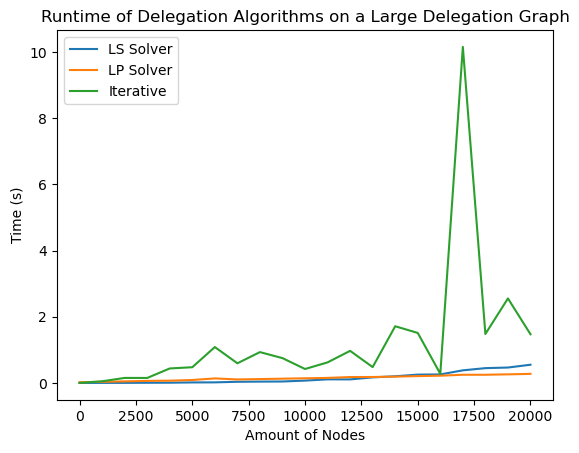

In [12]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  


plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms on a Large Delegation Graph")
plt.show()

In [13]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]
time_data_iterative
[[6.632804870605468e-05, 0.0495220422744751, 0.15111804008483887, 0.15019595623016357, 0.4369748830795288, 0.4743610620498657, 1.0841729640960693, 0.5932064056396484, 0.9310190677642822, 0.7491109371185303, 0.42061448097229004, 0.620352029800415, 0.969169020652771, 0.47835254669189453, 1.712231993675232, 1.5102109909057617, 0.27622854709625244, 10.150683045387268, 1.478222131729126, 2.5528050661087036, 1.4707720279693604]]
time_data_le
[[2.9087066650390624e-07, 0.0010924339294433594, 0.001885056495666504, 0.004586577415466309, 0.006742596626281738, 0.014842033386230469, 0.017030954360961914, 0.03418540954589844, 0.039609432220458984, 0.04307961463928223, 0.06997346878051758, 0.10811853408813477, 0.10631108283996582, 0.16739904880523682, 0.2010430097579956, 0.2511260509490967, 0.25702714920043945, 0.37995052337646484, 0.44664394855499

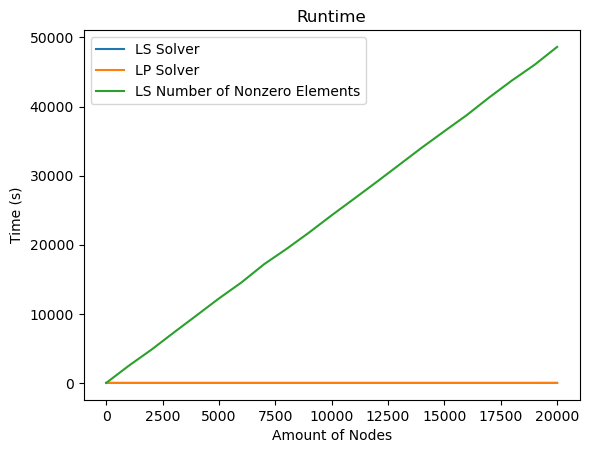

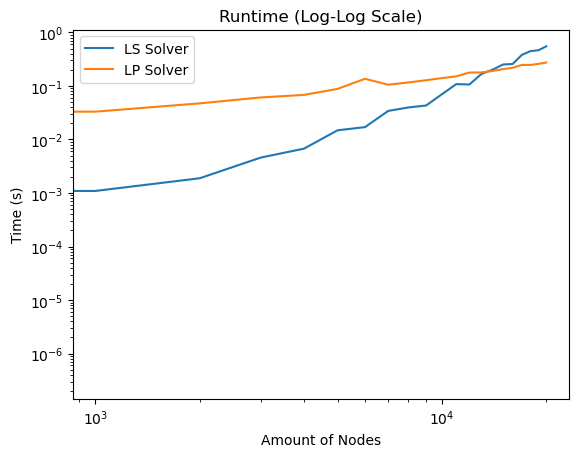

In [14]:
# --- First plot: Regular scale ---
plt.figure()
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label="LS Solver")
    plt.plot(x, time_data_lp[i], label="LP Solver")
    plt.plot(x, nnz_le[i], label="LS Number of Nonzero Elements")
    #plt.plot(x, time_data_iterative[i], label="Iterative")

plt.title("Runtime")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

# --- Second plot: Log-log scale ---
plt.figure()
for i in range(len(time_data_lp)):
    plt.loglog(x, time_data_le[i], label="LS Solver")
    plt.loglog(x, time_data_lp[i], label="LP Solver")
    #plt.loglog(x, time_data_iterative[i], label="Iterative")

plt.title("Runtime (Log-Log Scale)")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


# Very Large Graphs

In [ ]:
LOOPS = 5
SEED = 0

range_x = range(0, 50001, 5000)

time_data_le = []
time_data_lp = []
time_data_iterative = []

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            delegations_orig, nodes = create_delegation_graph(num_nodes, num_loops=LOOPS, seed=num_nodes)
            delegations= graph_tools.invert_graph(delegations_orig)
            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 2
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 1000:
            n = 50

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)

    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

In [ ]:
y = time_data_le[0][1:]

results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_le = pd.DataFrame(results).T

display(df_results_le)


# Sample synthetic data (replace these with your real x and y)
y = time_data_lp[0][1:]

# Store model fits and R² values
results = {}

# 1. Power law: log-log
log_x = np.log(x[1:])
log_y = np.log(y)
slope, intercept, r_value, _, _ = linregress(log_x, log_y)
results['Power law'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 2. Exponential: log-y
slope, intercept, r_value, _, _ = linregress(x[1:], np.log(y))
results['Exponential'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 3. Linear: raw scale
slope, intercept, r_value, _, _ = linregress(x[1:], y)
results['Linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

# 4. Log-linear: log(x) vs. y
slope, intercept, r_value, _, _ = linregress(np.log(x[1:]), y)
results['Log-linear'] = {'R2': r_value**2, 'slope': slope, 'intercept': intercept}

df_results_lp = pd.DataFrame(results).T

display(df_results_lp)

In [ ]:
plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LS Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  


plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms on a Large Delegation Graph")
plt.show()

# --- First plot: Regular scale ---
le_pred = np.exp(df_results_le.loc['Power law'].loc['intercept']) *  (np.array(x) ** df_results_le.loc['Power law'].loc['slope'])
lp_pred = df_results_lp.loc['Linear'].loc['slope'] * np.array(x) + df_results_lp.loc['Linear'].loc['intercept']
lp_pred_power = np.exp(df_results_lp.loc['Power law'].loc['intercept']) * (np.array(x) ** df_results_lp.loc['Power law'].loc['slope'])

plt.figure()
for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label="LS Solver")
    plt.plot(x, time_data_lp[i], label="LP Solver")
    plt.plot(x, le_pred, label="LS fit")
    plt.plot(x, lp_pred, label="LP fit linear")
    plt.plot(x, lp_pred_power, label="LP fit power")
    #plt.plot(x, time_data_iterative[i], label="Iterative")

plt.title("Runtime")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

# --- Second plot: Log-log scale ---
plt.figure()
for i in range(len(time_data_lp)):
    plt.plot(x[1:], time_data_le[i][1:], label="LS Solver")
    plt.plot(x[1:], time_data_lp[i][1:], label="LP Solver")
    #plt.loglog(x, time_data_iterative[i], label="Iterative")

plt.loglog()
plt.title("Runtime (Log-Log Scale)")
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


In [ ]:
print(x)
print("time_data_iterative")
print(time_data_iterative)
print("time_data_le")
print(time_data_le)
print("time_data_lp")
print(time_data_lp)

# Dense vs Sparse

So far, most graphs we've looked at were sparse, since my graph generator's nodes have at most four delegations per node